## Import Libraries

In [28]:
import random
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
import pandas as pd
import math
import networkx as nx
import time
from sklearn.ensemble import RandomForestRegressor
import collections

## Define Functions

In [29]:
def core_link(adjacencyMatrix,core1,core2): 
    
    '''Returns 1 if it satisfies the constrain that a link 
    can no longer than 4 units and returns 0 otherwise'''
    
    #Dijkstra_path = []
    networkAdjacency=nx.from_numpy_matrix(adjacencyMatrix,create_using=nx.DiGraph())
    #Dijkstra_path=nx.dijkstra_path(networkAdjacency,core1,core2)    # Get the shortest path between cores
    Dijkstra_path=nx.shortest_path_length(networkAdjacency,core1,core2)
    if Dijkstra_path > 4:
        return 0
    else:
        return 1
    
def generate_mesh():
    
    '''Returns a list of cores connected to each other in a mesh'''
    
    core_connected=[]
    for i in range(63):
        # Since cores in the last row are connected to next core and the one above 
        if i in [56,57,58,59,60,61,62,63]:  
            core_connected.append([i,i+1])
        # Cores on extreme right are not connected to next core, they are connected to the one below
        elif i in [7,15,23,31,39,47,55]:    
            core_connected.append([i,i+8])
        # Cores are connected to the next and the one below that core
        else:
            core_connected.append([i,i+1])
            core_connected.append([i,i+8])
    return core_connected

def adjacency_matrix(coreConnections):
    
    '''Returns an adjacency matrix for the connected cores list.
    Thus, if cores 1 and 8 are connected, row 0, column 8 and row 8, column 0 is made 1.'''
    
    s=(64,64) 
    # Since, the cores are arranged in 8x8 grid, 64x64 matrix is created of all zeros
    mesh_matrix=np.zeros(s)
    # The matrix is written with 1 where connections are present
    for connect in coreConnections:
            mesh_matrix[connect[0]][connect[1]]=1
            mesh_matrix[connect[1]][connect[0]]=1
    return mesh_matrix

def link_move(core1,core2,Scurr,Tcurr):
    
    '''Returns a new adjacency matrix by performing link movement between desired cores following the 
    constrains that each new design has the same amount of links (112) and each core can have at most 
    7 links. In order to do this, the number of links for core 2 is counted and if it is 7, then perturb 
    function is called again which generated random cores again. To main 112 links in the design, one of 
    the core 1 connections are destroyed only if that core is connected to cores other than core 1 else 
    perturb function is called again.'''
    
    # Create a copy so that new connections are not made in the original adjacency matrix
    Scurr_copy=deepcopy(Scurr)   
    core_connect=[]
    coreCount=-1
    nLinks=np.sum(Scurr_copy[core2])   # number of cores core 2 is connected to
    if nLinks < 7:
        for i in Scurr_copy[core1]:
            coreCount+=1
            if i==1:
                core_connect.append(coreCount)
        # Randomly choose a core connected to core 1 to destroy the link between them 
        core_link_destroy=random.choice(core_connect)
        # check if the core chosen for destroying connection has only one connection
        if (np.sum(Scurr_copy[core_link_destroy])==1):  
            perturb(Scurr,Tcurr)
        else:
            # Make new links between core 1 and core 2 and destroy one of the link of core 1
            Scurr_copy[core1][core_link_destroy]=0
            Scurr_copy[core_link_destroy][core1]=0
            Scurr_copy[core1][core2]=1
            Scurr_copy[core2][core1]=1                
    else:
        perturb(Scurr,Tcurr)
    return Scurr_copy

def tile_swap(core1,core2,Tcurr):
    
    '''Returns a task vectors where taks are swapped'''
    
    Tcurr_copy=deepcopy(Tcurr)
    Tcurr_copy[core1], Tcurr_copy[core2] = Tcurr_copy[core2], Tcurr_copy[core1]
    return Tcurr_copy

def perturb(Scurr,Tcurr):
    
    '''Returns a new adjacency matrix and task vector as a result of performing link
    movement or task swap function randomly between the cores chosen randomly.'''
    
    # randomly generate 0 or 1 and call link_move() if 0 else call tile_swap()
    link_or_tile = random.randint(0,1)
    valid_core=0
    # randomly generate 2 cores to be generated or tasks to be swapped
    core1=random.randint(0,63)
    core2=random.randint(0,63)
    # create copy of original adjacency matrix to avoid changes in the original one
    Snew = deepcopy(Scurr)
    Tnew = deepcopy(Tcurr)
    # Call perturb again if the cores generated are same and if the cores are already connected
    if (Scurr[core1][core2]==1 or core1==core2):
        perturb(Scurr,Tcurr)
    else:
        if link_or_tile==0:
            # check whether core2 can be connected to core 1 
            #(i.e. if the constraints of having maximum 4 links between them is satisfied) 
            # else call pertrub again to generate random cores again.
            valid_core=core_link(Scurr,core1,core2)
            if valid_core == 1:
                Snew=link_move(core1,core2,Scurr,Tcurr)
            elif valid_core == 0:
                perturb(Scurr,Tcurr)
        elif link_or_tile==1:
            # Call tile swap to swap tasks on the task vector 
            Tnew=tile_swap(core1,core2,Tcurr)
    return Snew,Tnew

def generator_euclidean(nNodes,grid):
    
    '''Returns a matrix containing euclidean distance between the cores. 
    Eg. distance between core 0 and core 1 or core 0 and core 8 is 1 as they
    are directly connected and adjacent to each other whereas distance between 
    core 0 and core 9 is 1.414(i.e. sqrt(1+1)).'''
    
    euclideanMatrix = np.zeros((nNodes,nNodes))
    for row in range(nNodes):
        value =row / grid
        xCoordinate = (int)(value)
        yCoordinate = row % grid
        for col in range(nNodes):
            value=col / grid
            x1Coordinate = (int)(value)
            y1Coordinate = col % grid
            xDistance = (x1Coordinate-xCoordinate)**2
            yDistance = (y1Coordinate-yCoordinate)**2
            # Calculate euclidean distance
            euclideanMatrix[row][col] = (xDistance + yDistance)**0.5
    return euclideanMatrix


def calc_hopCount(adjacencyMatrix,nNodes):
    
    '''Returns the hop count matrix which is the total number of cores in the path between the two cores'''
    
    hopCount=np.zeros((nNodes,nNodes))  # Matrix of 64x64 of all zeros
    networkAdjacency=nx.from_numpy_matrix(adjacencyMatrix,create_using=nx.DiGraph())
    for i in range(nNodes):
        for j in range(nNodes):
             # Get the shortest path length for each core to every other core
            hopCount[i][j]=nx.shortest_path_length(networkAdjacency,i,j)  
    return hopCount

def cal_linkLength(adjacencyMatrix,euclidean,nNodes):
    
    '''Returns the link length matrix which is sum of link lengths between the cores.
    The link length is one if cores if cores are connected adjacent to each other else euclidean distance 
    is the link length.'''
    
    linkLength=np.zeros((nNodes,nNodes))
    # This gives the euclidean distance for the cores connected in the given design
    lengthMatrix=np.multiply(adjacencyMatrix,euclidean)    
    networkLength=nx.from_numpy_matrix(lengthMatrix,create_using=nx.DiGraph())
    pathDijkstra=[]
    for i in range(nNodes):
        for j in range(nNodes):
            if i==j:
                linkLength[i][j]=0
            else:
                # get the Dijkstra path between the cores
                pathDijkstra=nx.dijkstra_path(networkLength,i,j)
                source_destination=[]
                pathLength=[]
                for x in range(len(pathDijkstra)-1):
                    source_destination.append([pathDijkstra[x],pathDijkstra[x+1]])
                # Get the length of links from length Matrix for the cores connected in path
                for cores in source_destination:
                    pathLength.append(lengthMatrix[cores[0]][cores[1]])
                # Add the link lengths of the cores connected in Dijkstra path
                linkLength[i][j]=np.sum(pathLength)
    return linkLength

def objective(adjacencyMatrix,taskMatrix,euclidean,traffic_data,nNodes):
    
    '''Returns the cost of the given design using the formula given in the question.'''
    
    hopCountMatrix=np.zeros((nNodes,nNodes))
    linkLengthMatrix=np.zeros((nNodes,nNodes))
    costVector=[]
    cost=0
    costFinal=0
    # get the hop count matrix for the given design
    hopCountMatrix=calc_hopCount(adjacencyMatrix,nNodes)
    # get the link length matrix for the given design
    linkLengthMatrix=cal_linkLength(adjacencyMatrix,euclidean,nNodes) 
    # Calculate total cost for the design
    for i in range(nNodes):
        for j in range(nNodes):
            task=taskMatrix[j]
            # take the traffic data from the task matrix
            cost=((3*hopCountMatrix[i][j] + math.ceil(linkLengthMatrix[i][j])) * traffic_data[task][i])
            costVector.append(cost)
    costFinal=np.sum(costVector)
    return costFinal


## STAGE Algorithm

In [34]:
def stage(euclidean,traffic_data,numIter,countRepeat,memoryX,memoryY,Scurr,Tcurr,Ccurr):
    
    '''Implements the stage algorithm.'''
    
    nNodes=64
    grid=8
    # create deque of a fixed length
    cost_queue=collections.deque(maxlen=countRepeat)
    predict_queue=collections.deque(maxlen=countRepeat)
    # clear the deque for each run of stage
    cost_queue.clear()
    predict_queue.clear()
    training_data=[]
    for i in range(numIter):
        # Get new design using perturb function
        Sneigh,Tneigh = perturb(Scurr,Tcurr)
        # Calculate cost for the new design
        Cneigh=objective(Sneigh,Tneigh,euclidean,traffic_data,nNodes)
        # replace the old design with the new one if the cost of new design is less
        if Cneigh < Ccurr:
            Scurr=Sneigh
            Tcurr=Tneigh
            Ccurr=Cneigh
        current_feature=[]
        features=[]
        # Get the upper triangular of adjacency matrix
        up_tril=Scurr[np.triu_indices(nNodes, k = 1)]
        input_features=[up_tril,Tcurr]
        # create features vector containing adjacency vector and task vector
        features=[x for y in input_features for x in y]
        for i in features:
            current_feature.append(i)
        # append the database for the regressor
        memoryX.append(current_feature)
        training_data.append(current_feature)        
        cost_queue.append(Ccurr)
        # Check whether the cost values vary rapidly or within a small range. 
        # If cost values do not change drastically for a specified number of repeats
        # then terminate
        if len(cost_queue)==countRepeat:
            cost_val=cost_queue[0]
            min_costVal=cost_val-100
            max_costVal=cost_val+100
            count=0
            for i in range(len(cost_queue)):
                if (min_costVal < cost_queue[i]) and (max_costVal > cost_queue[i]):
                    count=count+1
            if count==countRepeat:
                Ccurr = cost_queue[countRepeat-1]
                break
    # Train the regressor with the training data
    xTrain=np.array(memoryX)
    len_training=len(training_data)
    # labels are the cost value of the last design
    labels = [Ccurr]*len_training
    for i in labels:
        memoryY.append(i)
    yTrain = memoryY
    regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
    regressor.fit(xTrain, yTrain)  
    Pcurr=Ccurr
    for i in range(numIter):
        training_Sneigh=[]
        current_feature1=[]
        features1=[]   
        # Apply perturb on the last target design
        Sneigh,Tneigh = perturb(Scurr,Tcurr)
        # create the test vector of adjacency vector and task vector to provide 
        # input to the regressor for prediction
        up_tril1=Sneigh[np.triu_indices(nNodes, k = 1)]
        input_features1=[up_tril1,Tneigh]
        features1=[x for y in input_features1 for x in y]
        for i in features1:
            current_feature1.append(i)
        training_Sneigh.append(current_feature1)
        Pneigh = regressor.predict(training_Sneigh)   
        # Minimize the evaluation function of the regressor
        if Pneigh < Pcurr:
            Scurr=Sneigh
            Tcurr=Tneigh
            Pcurr=Pneigh
        predict_queue.append(Pcurr)
        # Stopping condition if the prediction values do not change for given number of repeats
        if len(predict_queue)==countRepeat:
            predict_val=predict_queue[0]
            min_predictVal=predict_val-100
            max_predictVal=predict_val+100
            countP=0
            for i in range(len(predict_queue)):
                if (min_predictVal < predict_queue[i]) and (max_predictVal > predict_queue[i]):
                    countP=countP+1
            if countP==countRepeat:
                Pcurr = predict_queue[countRepeat-1]
                break
    return Scurr,Tcurr,Ccurr,memoryX,memoryY

In [37]:
def callStage(traffic_data,numIter,countRepeat):
    
    '''This function calls stage recursively'''
    
    start=time.time()
    # memoryX and memoryY are used to append the training data and lables for each iteration of stage
    memoryX=[]
    memoryY=[]
    cost_queue1=collections.deque(maxlen=countRepeat)
    cost_queue1.clear()
    
    nNodes=64
    grid=8
    # get the euclidean distance matrix
    EuclideanDistance=generator_euclidean(nNodes,grid) 
    euclidean=np.array(EuclideanDistance)  
    # Base Condition is mesh
    coreConnections=generate_mesh()
    Scurr=adjacency_matrix(coreConnections)
    Tcurr=[i for i in range(64)]
    Ccurr=objective(Scurr,Tcurr,euclidean,traffic_data,nNodes)
    print("Cost function for Mesh",Ccurr)
    
    for i in range(numIter):
        # memoryX and memoryY is appended for each iteration with the previous data and the last design 
        # is fed as base to the new design
        Scurr,Tcurr,Ccurr,memoryX,memoryY=stage(euclidean,traffic_data,numIter,countRepeat,memoryX,memoryY,Scurr,Tcurr,Ccurr)
        # stopping condition for Stage
        print("Cost Value after Stage",Ccurr)
        cost_queue1.append(Ccurr)
        if len(cost_queue1)==countRepeat:
            cost_val=cost_queue1[0]
            min_costVal=cost_val-100
            max_costVal=cost_val+100
            count=0
            for i in range(len(cost_queue1)):
                if (min_costVal < cost_queue1[i]) and (max_costVal > cost_queue1[i]):
                    count=count+1
            if count==countRepeat:
                Ccurr = cost_queue1[countRepeat-1]
                break   
    end=time.time()
    print("Total Execution Time:",end-start)
    return Scurr,Tcurr,Ccurr

## Read csv Files

In [53]:
traffic_uniform = pd.read_csv("traffic_uniform.csv", delimiter=",", header=None)
traffic_complement = pd.read_csv("traffic_complement.csv", delimiter=",", header=None)
traffic_rand = pd.read_csv("traffic_rand.csv", delimiter=",", header=None)

## For Random Traffic

In [38]:
Scurr,Tcurr,Ccurr=callStage(traffic_rand,1000,50)

Cost function for Mesh 43422.86699857061
Cost Value after Stage 32908.695716904695
Cost Value after Stage 32652.008493842426
Cost Value after Stage 32230.021647629266
Cost Value after Stage 31871.25962922554
Cost Value after Stage 31651.283152068958
Cost Value after Stage 31606.109668602367
Cost Value after Stage 31606.109668602367
Cost Value after Stage 31580.58351330178
Cost Value after Stage 31182.874243866616
Cost Value after Stage 31067.644558033182
Cost Value after Stage 30993.747392950034
Cost Value after Stage 30901.44520622122
Cost Value after Stage 30872.00469340088
Cost Value after Stage 30808.512307370802
Cost Value after Stage 30741.38978241639
Cost Value after Stage 30720.243145694316
Cost Value after Stage 30720.243145694316
Cost Value after Stage 30698.16875649923
Cost Value after Stage 30681.360223868898
Cost Value after Stage 30673.094053795492
Cost Value after Stage 30624.73372052695
Cost Value after Stage 30586.176268181305
Cost Value after Stage 30567.99723212969
C

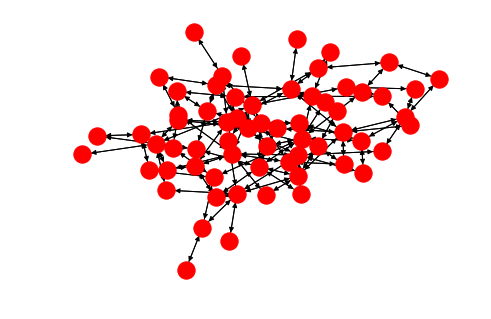

In [44]:
Noc_stage1=nx.from_numpy_matrix(Scurr,create_using=nx.DiGraph())
nx.draw(Noc_stage1,node=True)

In [45]:
Tcurr

[49,
 62,
 44,
 1,
 51,
 40,
 3,
 28,
 20,
 59,
 13,
 60,
 29,
 58,
 36,
 47,
 24,
 30,
 27,
 12,
 57,
 4,
 25,
 17,
 61,
 16,
 26,
 10,
 56,
 50,
 18,
 33,
 22,
 46,
 43,
 42,
 52,
 15,
 5,
 38,
 55,
 2,
 53,
 8,
 35,
 6,
 32,
 9,
 7,
 54,
 63,
 37,
 39,
 23,
 48,
 41,
 31,
 19,
 45,
 34,
 11,
 14,
 0,
 21]

In [46]:
Scurr1,Tcurr1,Ccurr1=callStage(traffic_rand,100,20)

Cost function for Mesh 43422.86699857061
Cost Value after Stage 38955.21560831234
Cost Value after Stage 38933.591767640915
Cost Value after Stage 38664.84123340639
Cost Value after Stage 37060.83490035515
Cost Value after Stage 36454.392563272755
Cost Value after Stage 36168.00825162469
Cost Value after Stage 36168.00825162469
Cost Value after Stage 34381.561649899355
Cost Value after Stage 34348.49626896405
Cost Value after Stage 34225.21449402303
Cost Value after Stage 34175.096286649336
Cost Value after Stage 33672.07909849046
Cost Value after Stage 33667.60039601978
Cost Value after Stage 33275.02271295168
Cost Value after Stage 32964.32618460026
Cost Value after Stage 32767.464413502978
Cost Value after Stage 32767.464413502978
Cost Value after Stage 32751.48047254508
Cost Value after Stage 32749.328309884564
Cost Value after Stage 32627.433193217563
Cost Value after Stage 32502.789250828762
Cost Value after Stage 32385.58515524061
Cost Value after Stage 32357.8237926868
Cost Val

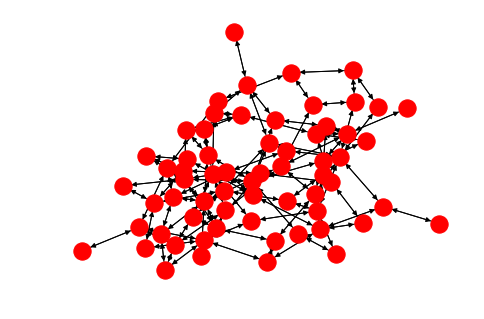

In [47]:
Noc_stage2=nx.from_numpy_matrix(Scurr1,create_using=nx.DiGraph())
nx.draw(Noc_stage2,node=True)

In [48]:
Tcurr1

[34,
 20,
 46,
 28,
 47,
 1,
 52,
 8,
 42,
 15,
 57,
 45,
 49,
 55,
 51,
 32,
 36,
 58,
 39,
 5,
 10,
 53,
 40,
 60,
 37,
 3,
 59,
 0,
 35,
 56,
 4,
 14,
 2,
 54,
 29,
 30,
 31,
 12,
 19,
 61,
 16,
 13,
 63,
 41,
 25,
 26,
 33,
 9,
 21,
 6,
 43,
 17,
 48,
 23,
 44,
 7,
 22,
 50,
 38,
 11,
 18,
 62,
 24,
 27]

## For Uniform Traffic

Cost function for Mesh 34384.451593398655
Cost Value after Stage 31773.093992376536
Cost Value after Stage 31732.015878379287
Cost Value after Stage 28611.786357753335
Cost Value after Stage 28602.55128484858
Cost Value after Stage 28267.074804672993
Cost Value after Stage 28267.074804672993
Cost Value after Stage 27980.546080772554
Cost Value after Stage 27910.8959455107
Cost Value after Stage 27777.668190936114
Cost Value after Stage 27665.155870311435
Cost Value after Stage 27591.60498967716
Cost Value after Stage 27562.301367158943
Cost Value after Stage 27311.411698353673
Cost Value after Stage 27151.934156055402
Cost Value after Stage 27143.823058950737
Cost Value after Stage 27053.622263962665
Cost Value after Stage 27050.168770054104
Cost Value after Stage 26688.49995658555
Cost Value after Stage 26399.764870335937
Cost Value after Stage 26386.07916244777
Cost Value after Stage 26144.406170649483
Cost Value after Stage 26110.99600733087
Cost Value after Stage 26031.621521238838

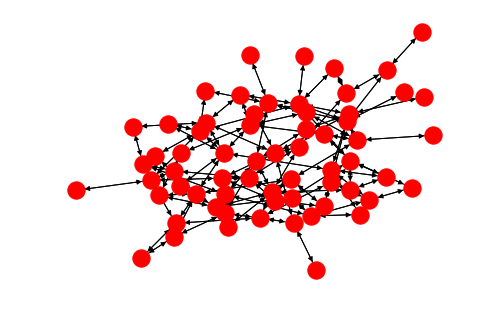

In [49]:
ScurrU,TcurrU,CcurrU=callStage(traffic_uniform,100,20)
Noc_stageU=nx.from_numpy_matrix(ScurrU,create_using=nx.DiGraph())
nx.draw(Noc_stageU,node=True)

In [50]:
TcurrU

[23,
 59,
 37,
 40,
 57,
 49,
 50,
 51,
 19,
 21,
 39,
 46,
 15,
 48,
 8,
 34,
 17,
 30,
 60,
 43,
 62,
 42,
 5,
 63,
 52,
 14,
 45,
 26,
 55,
 33,
 56,
 61,
 28,
 47,
 54,
 29,
 0,
 1,
 3,
 41,
 22,
 7,
 58,
 27,
 9,
 13,
 4,
 11,
 31,
 16,
 6,
 38,
 18,
 2,
 10,
 20,
 53,
 44,
 24,
 32,
 25,
 12,
 36,
 35]

## For Complement Traffic

Cost function for Mesh 10052.9357927789
Cost Value after Stage 9469.536690408277
Cost Value after Stage 9098.011236211372
Cost Value after Stage 8812.131661005544
Cost Value after Stage 8510.095927830564
Cost Value after Stage 8355.092279310367
Cost Value after Stage 8341.515943253464
Cost Value after Stage 8262.210166721714
Cost Value after Stage 8156.867939570098
Cost Value after Stage 8127.170891778444
Cost Value after Stage 8004.506260305308
Cost Value after Stage 7928.6486845238815
Cost Value after Stage 7895.366833275212
Cost Value after Stage 7791.93553040314
Cost Value after Stage 7690.955072542794
Cost Value after Stage 7668.505197734326
Cost Value after Stage 7637.377216086053
Cost Value after Stage 7623.6219519754795
Cost Value after Stage 7616.559926774367
Cost Value after Stage 7605.244722230638
Cost Value after Stage 7598.077061718535
Cost Value after Stage 7598.077061718535
Cost Value after Stage 7535.33540965918
Cost Value after Stage 7529.163118091621
Cost Value after 

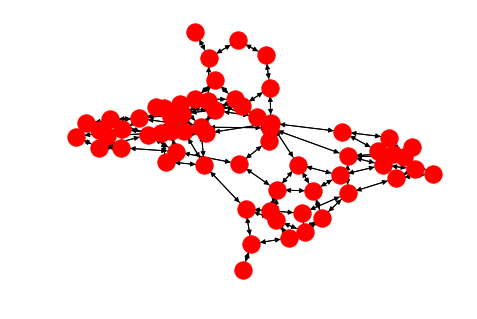

In [51]:
ScurrC,TcurrC,CcurrC=callStage(traffic_complement,100,20)
Noc_stageC=nx.from_numpy_matrix(ScurrC,create_using=nx.DiGraph())
nx.draw(Noc_stageC,node=True)

In [52]:
TcurrC

[5,
 63,
 12,
 61,
 59,
 33,
 30,
 52,
 38,
 39,
 46,
 55,
 51,
 6,
 43,
 49,
 47,
 57,
 18,
 60,
 4,
 34,
 3,
 25,
 62,
 53,
 37,
 36,
 15,
 28,
 48,
 54,
 31,
 23,
 14,
 44,
 27,
 29,
 32,
 24,
 42,
 41,
 20,
 19,
 45,
 9,
 50,
 22,
 56,
 26,
 21,
 2,
 11,
 35,
 17,
 16,
 7,
 58,
 13,
 10,
 1,
 40,
 0,
 8]